# Data Quality Report 

## Index
1. Data introduction
2. Continues features
3. Categorial features
4. Data quality plan

## 1. Data introduction

In [133]:
import pandas as pd;
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [134]:
headers = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'ft_income'];
df = pd.read_csv('../../datasets/adults.csv', sep=', ', names=headers, na_values=['?'])

df.head(5)

# df = df.dropna(subset=["native-country"])
df.isna().sum()

C:\Users\aukev\AppData\Local\Temp\ipykernel_11960\3064394077.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('../../datasets/adults.csv', sep=', ', names=headers, na_values=['?'])


age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
ft_income            0
dtype: int64

In [135]:
X = df.drop('ft_income',axis=1)
y = df['ft_income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 ) 

## 2. Continues features

A data quality report shows the metrics of the features

In [136]:
def continues(dataset, features):
    headers = ["feature","count", "% miss.", "card.", "min", "1st Qrt.", "mean", "median", "3rd Qrt.", "max", "std dev."] 
    report = []
    for feature in features:
        report.append([
            feature,
            dataset[feature].size,
            (dataset[feature].isnull().sum() / dataset[feature].size) * 100,
            dataset[feature].nunique(),
            dataset[feature].min(),
            dataset[feature].quantile(0.25),
            dataset[feature].mean(),
            dataset[feature].median(),
            dataset[feature].quantile(0.75),
            dataset[feature].max(),
            dataset[feature].std(),
        ])
    return pd.DataFrame(report, columns=headers)

continues_features = ['fnlwgt','age','capital-gain', 'capital-loss', 'hours-per-week']
continues_report = X_train.pipe(continues, continues_features)
continues_report

,feature,count,% miss.,card.,min,1st Qrt.,mean,median,3rd Qrt.,max,std dev.
0,fnlwgt,26048,0.0,18440,12285,117963.0,189759.2,178263.5,237006.5,1484705,105232.9
1,age,26048,0.0,73,17,28.0,38.6,37.0,48.0,90,13.6
2,capital-gain,26048,0.0,115,0,0.0,1053.6,0.0,0.0,99999,7230.8
3,capital-loss,26048,0.0,87,0,0.0,88.0,0.0,0.0,4356,403.6
4,hours-per-week,26048,0.0,93,1,40.0,40.4,40.0,45.0,99,12.3


### Outliers
Are data points that represent anomalies. They need to be removed.

By plotting the data distribution, we can see if we need to remove some outliers to enhance the dataset

In [137]:
def ceildiv(a, b): return -(a // -b)

def graphs(plot_func, features, cols=4, height=6):
    rows = ceildiv(len(features), cols)
    _, axes = plt.subplots(nrows=rows,ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for i, feature in enumerate(features):
        loc = axes[i // cols, i % cols] if rows > 1 and cols > 1 else axes[i % cols]
        plot_func(feature, loc)
    return plt 

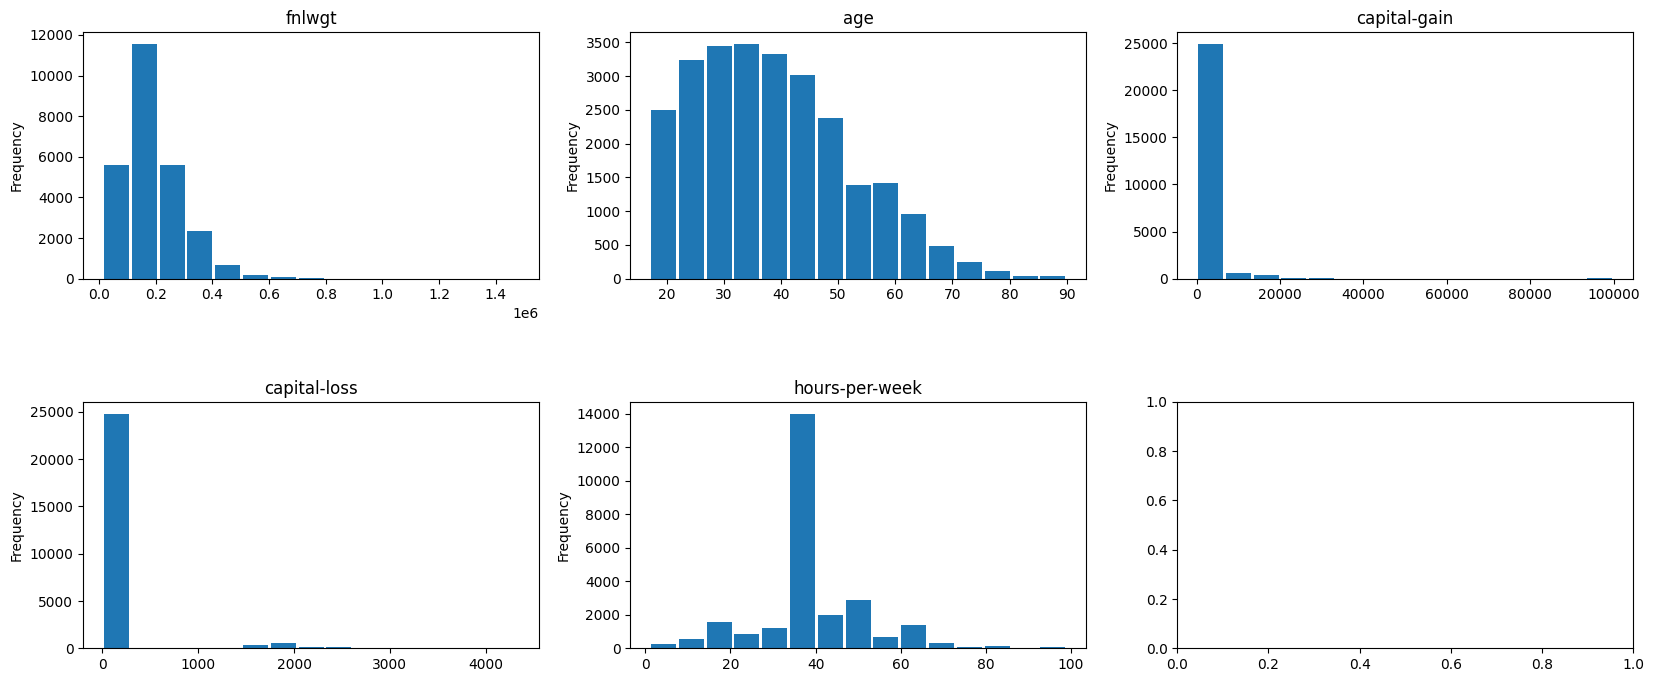

In [138]:
# graph_plot = lambda feature, loc: df[feature].plot(kind='kde', ax=loc, title=feature)
graph_plot = lambda feature, loc: X_train[feature].plot(kind='hist', ax=loc, title=feature, rwidth=0.9, bins=15)
plt = graphs(graph_plot, continues_features, 3, 4)
plt.show()

There are multiple ways to remove outliers: 
- z-score: `(x - x̄) / σ`, this returns the standard deviation of the data point, we remove all that exceed and sd of 3
- IQR: putting a range based on the Inter Quartile Range is more resilient against data skew since z-score assumes normal distribution.

We're ignoring capital gain and capital-loss because of the data skew, >90% is 0 so _everything else is an outlier_

before: 26048 rows
after: 18199 rows


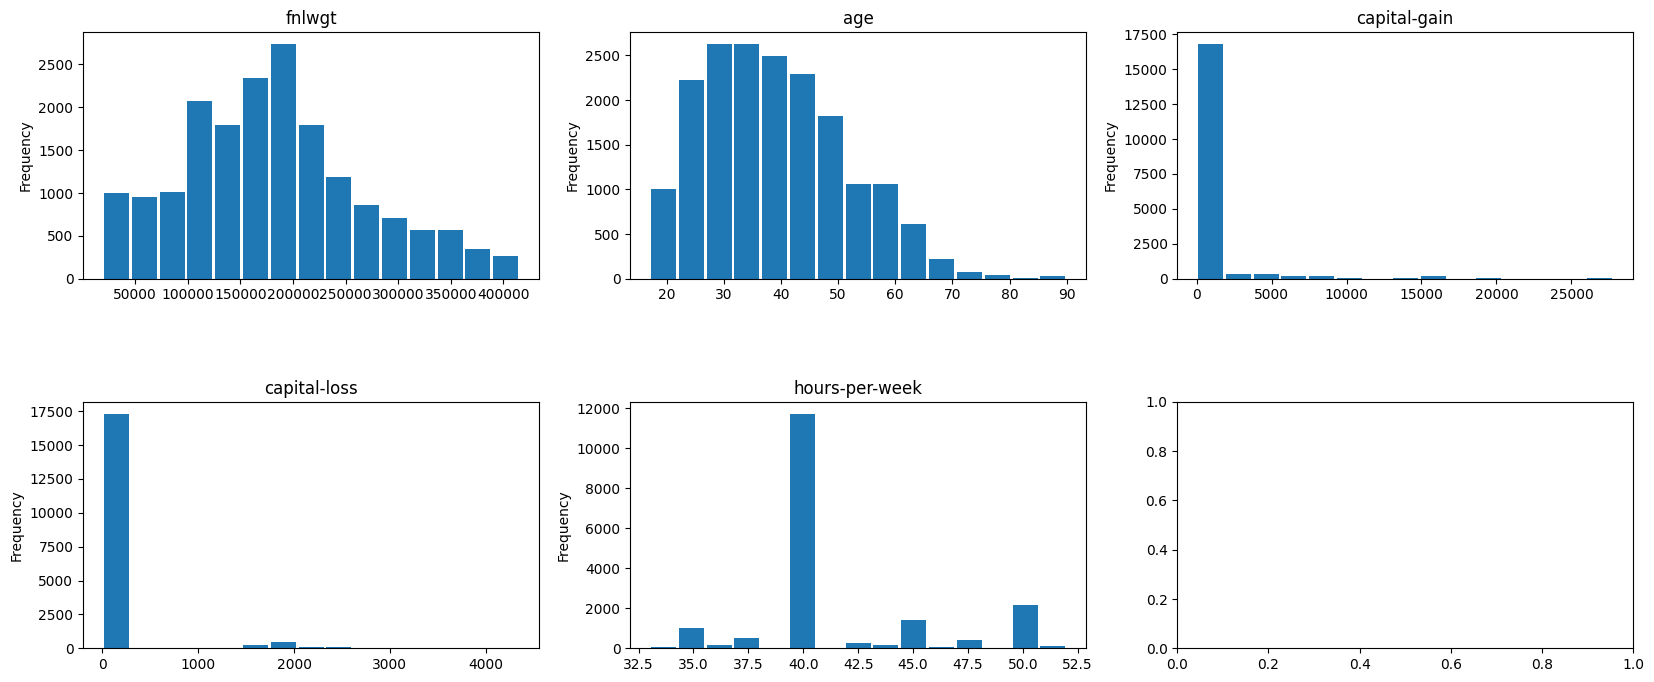

In [139]:
# Remove outliers
def z_score_outlier_removal(dataset: pd.DataFrame, features): 
    filter_outliers = pd.Series(True, index=dataset.index)

    for f in features:
        mean = dataset[f].mean()
        sd = dataset[f].std()
        filter_outliers &= (dataset[f] - mean).abs() / sd <= 3

    return dataset[filter_outliers] 

def iqr_score_outlier_removal(dataset: pd.DataFrame, features): 
    filter_outliers = pd.Series(True, index=dataset.index)

    for f in features:
        Q1 = dataset[f].quantile(0.25)
        Q3 = dataset[f].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (1.5 * IQR)
        filter_outliers &= dataset[f] > lower_bound

        upper_bound = Q3 + (1.5 * IQR)
        filter_outliers &= dataset[f] < upper_bound

    return dataset[filter_outliers] 

print(f"before: {X_train.shape[0]} rows")
X_train = iqr_score_outlier_removal(X_train, ["fnlwgt", "hours-per-week"]) # , "age"

# Manual removal of outliers
X_train = X_train[X_train["capital-gain"] < 30000]
print(f"after: {X_train.shape[0]} rows")

graph_plot = lambda feature, loc: X_train[feature].plot(kind='hist', ax=loc, title=feature, rwidth=0.9, bins=15)
plt = graphs(graph_plot, continues_features, 3, 4)
plt.show()


Perc of value 33 in hours-per-week is 0.15935%
Perc of value 52 in hours-per-week is 0.60992%


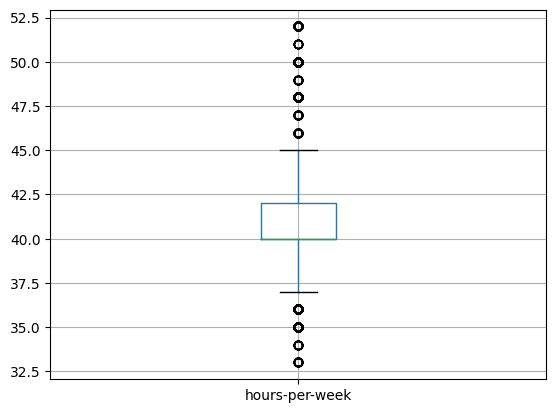

In [140]:
f = 'hours-per-week'

def boxplot_vals(dataset, feature): 
    Q1 = dataset[feature].quantile(0.25)
    mean = dataset[feature].mean()
    Q3 = dataset[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, Q1, mean, Q3, upper_bound

_, _, median, _, upper_bound = boxplot_vals(X_train, f)

min = X_train[f].min()
min_perc = X_train[X_train[f] == min].shape[0] / X_train.shape[0] * 100
print(f'Perc of value {min} in {f} is {round(min_perc, 5)}%')

max = X_train[f].max()
max_perc = X_train[X_train[f] == max].shape[0] / X_train.shape[0] * 100
print(f'Perc of value {max} in {f} is {round(max_perc, 5)}%')

boxplot = X_train.boxplot(column=[f]) 

Hmmm, not very _gaussian_ of this dataset

### 3. Categorial features

In [141]:
def categorial(dataset, features):
    headers = ["feature","count", "% miss.", "card.", "Mode", "Mode freq.", "Mode %", "2nd Mode", "2nd Mode freq.", "2nd Mode %"]
    report = []
    for feature in features:
        report.append([
            feature,
            dataset[feature].size,
            dataset[feature].isnull().sum() / dataset[feature].size,
            dataset[feature].nunique(),
            dataset[feature].mode().values[0],
            dataset[feature].value_counts().max(),
            (dataset[feature].value_counts().max() / dataset[feature].size) * 100,
            dataset[feature].value_counts().index[1],
            dataset[feature].value_counts().iloc[1],
            (dataset[feature].value_counts().iloc[1] / dataset[feature].size) * 100,
        ])
    return pd.DataFrame(report, columns=headers)

categorial_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
categorial_report = X_train.pipe(categorial, categorial_cols)
categorial_report

,feature,count,% miss.,card.,Mode,Mode freq.,Mode %,2nd Mode,2nd Mode freq.,2nd Mode %
0,workclass,18199,0.0,8,Private,13100,72.0,Local-gov,1311,7.2
1,education,18199,0.0,16,HS-grad,6231,34.2,Some-college,3815,21.0
2,marital-status,18199,0.0,7,Married-civ-spouse,8842,48.6,Never-married,5392,29.6
3,occupation,18199,0.0,14,Craft-repair,2673,14.7,Exec-managerial,2361,13.0
4,relationship,18199,0.0,6,Husband,7856,43.2,Not-in-family,4719,25.9
5,race,18199,0.0,5,White,15446,84.9,Black,1804,9.9
6,sex,18199,0.0,2,Male,12455,68.4,Female,5744,31.6
7,native-country,18199,0.0,41,United-States,16254,89.3,Mexico,360,2.0


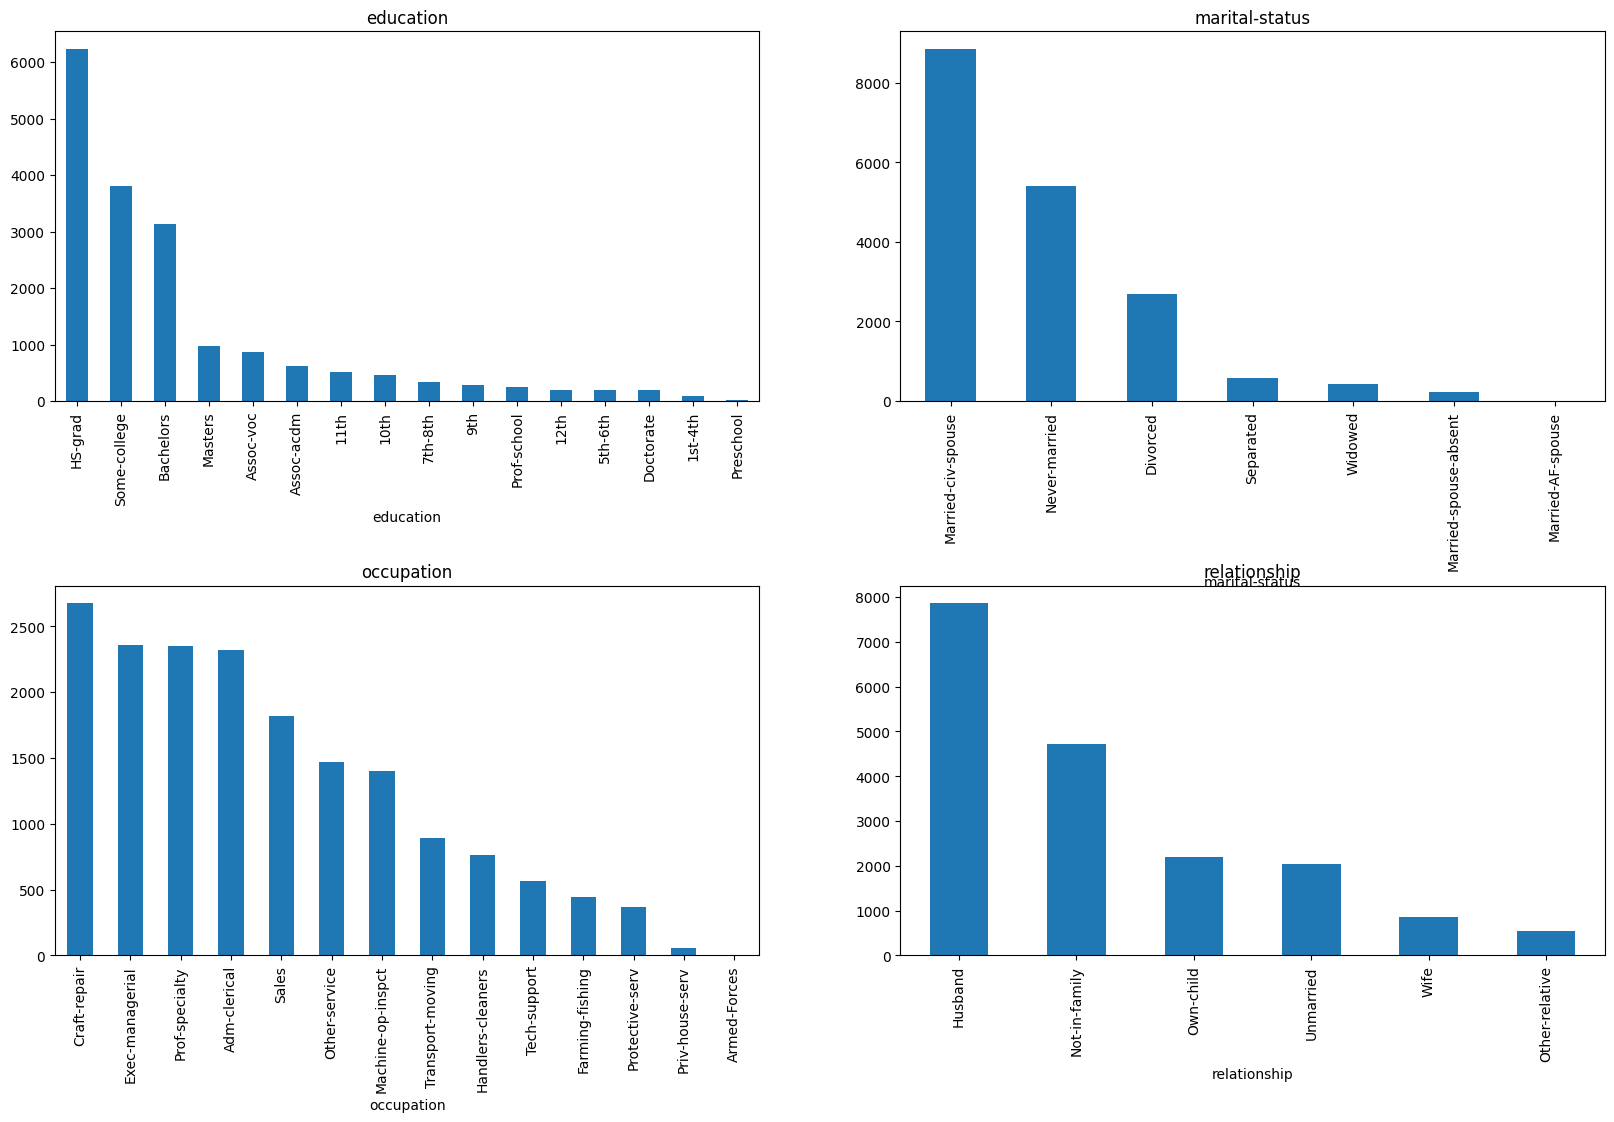

In [142]:
graph_plot = lambda feature, loc: X_train[feature].value_counts().plot(kind='bar', ax=loc, title=feature)
plt = graphs(graph_plot, categorial_cols[1:5], 2, 6)
plt.show()

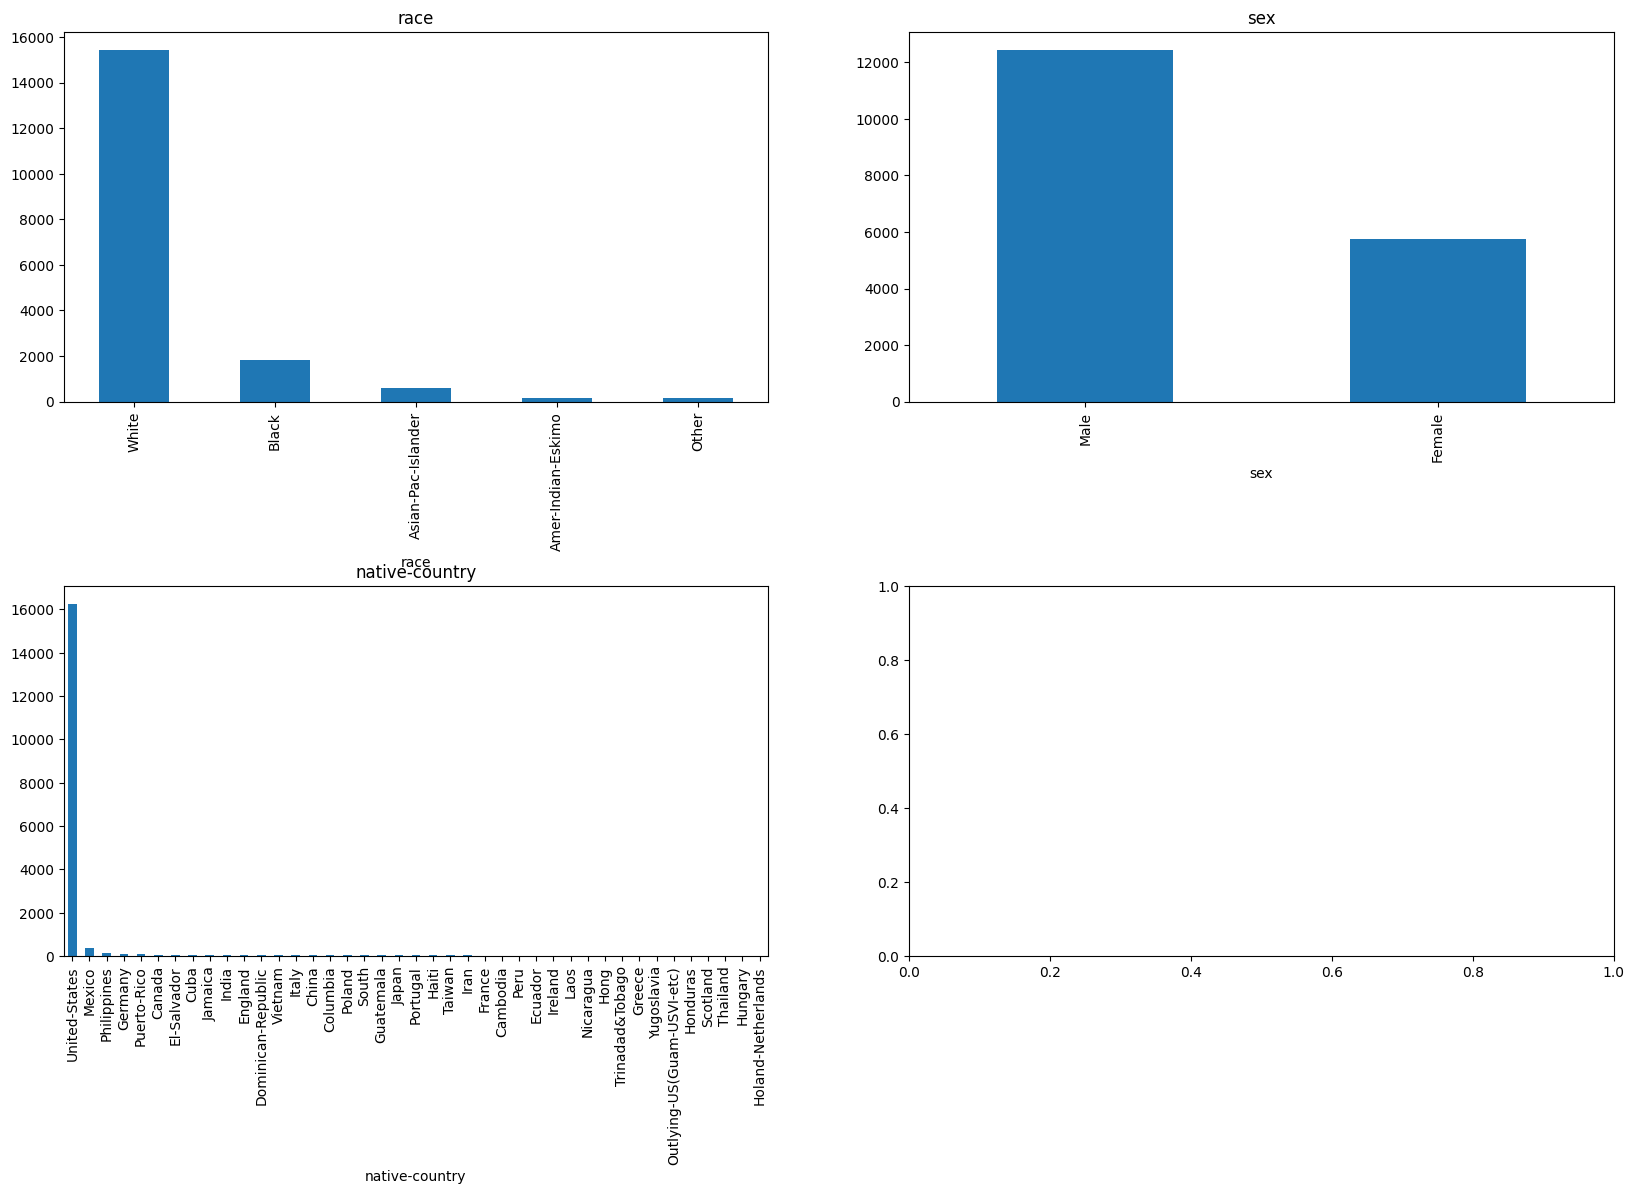

In [143]:
graph_plot = lambda feature, loc: X_train[feature].value_counts().plot(kind='bar', ax=loc, title=feature)
plt = graphs(graph_plot, categorial_cols[5:], 2, 6)
plt.show()

## 4. Data quality plan

**Missing values**
rules: 
- more than 60% = remove feature

**Irregular Cardinality**
rules: 
- Card. of 1 = useless feature
- low card. = make column categorial
- high card. = make column continues
- if categorial, map 'similar' values to 1 value-type (['m', 'M', 'Male', 'Man'] => 'm')
- categorial columns with a Card. of >50 = potential problem

**Outliers**
- values with gap bigger than gap of median and 3rd Q is bad (see IQR)


| Feature | Data Quality Issue | Potential Handling Strategies |
|:--------:|:--------:|:--------:|
| capital-gain | Outliers |   |
| capital-loss | Outliers |   |
| hours-per-week | Outliers |   |